In [1]:
import pickle
pickle_in = open("/home/penglab/FeaCal/neuron_set.pickle","rb")
example_ = pickle.load(pickle_in)

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.96
Loading CCF brain structure data...
Loading time: 0.01


In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
# ns=nmt.neuron_set('/Users/pengxie/Documents/Research/fullMorph_classification/data/registered_swc/Janelia_test/swc/Whole/')
ns_xie = example_[0]


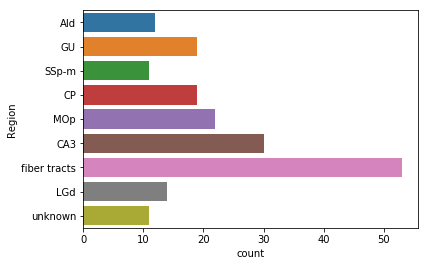

In [46]:
sf = ns_xie.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )
_ = ns_xie.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)


## function fromSOMAtoAXON() will return a dataframe 
* first a DataFrame will be generated, 

* **clusterDF** stores the information of clustering result, with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']


In [66]:
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def normalize(df, log=True):
    scaled_data = np.array(df) / np.sum(df, axis=0).values.reshape(-1,1) * 100000
    if log:
        scaled_data = np.log(scaled_data+100)
    scaled_dataDF = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    return scaled_dataDF

def fromSOMAtoAXON(ns):
    somaDF = ns.features['soma_features'].region
    axonDF = ns.features['projection_features'].raw_data
    normaF=0

    somaregionDF = somaDF.copy()
    axonregionDF = axonDF.copy()      

    colname = ['Cluster Num','soma Region List','axon Region List']

    typeR, typeC = np.unique(ns.metadata['Cluster'] , return_counts = True)
    detailDF = pd.DataFrame(index = typeR,columns = ['swc list','soma region','max soma','total soma',
                                                             'max axon'])

        # for each cluster result UNDER EACH PARAMETER
    somaCLUSTERlist = []
    axonCLUSTERlist = []

    #axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
    for label_idx in detailDF.index:
        axonTEMPdf = pd.DataFrame(index = axonregionDF.columns)
        swcINlabel = ns.metadata[ns.metadata['Cluster']==label_idx]
        detailDF.loc[label_idx,'swc list'] = (swcINlabel.index).tolist()
        #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
        detailDF.loc[label_idx,'soma region'] = swcINlabel['SomaRegion'].tolist()
        del_soma_region = detailDF.loc[label_idx,'soma region']
        while 'unknown' in del_soma_region:
            del_soma_region.remove('unknown')
            del_soma_region.append('others')
        while 'fiber tracts' in del_soma_region:
            del_soma_region.remove('fiber tracts')
            del_soma_region.append('others')
        IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
        #sort the counting
        count_sort_ind = np.argsort(-IDcounts)
        dicitem = []
        for i in range(1,min(len(IDrange)+1,4)):
            dicitem.append(str(i)+'somaR')
        for i in range(1,min(len(IDrange)+1,4)):
            dicitem.append(str(i)+'somaC')
        #select the first three regions
        dicvalue = IDrange[count_sort_ind][0:min(3,len(IDrange))]
        dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(3,len(IDrange))])
        detailDF.loc[label_idx,'max soma'] = str(dict(zip(dicitem, dicvalue)))
        detailDF.loc[label_idx,'total soma'] = swcINlabel.shape[0]

        #axonLABEL stores all the rows under same cluster
        axonregionDF.loc[:,'cluster'] = ns.metadata['Cluster'].copy()
        axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
        axonLABEL.drop('cluster', axis=1,inplace=True)
        axonTEMPdf[label_idx]=axonLABEL.sum()
        if 'contra_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['contra_fiber tracts'],inplace = True)
        if 'ipsi_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['ipsi_fiber tracts'],inplace = True)
        if normaF:
            #normalize the sum
            axonTEMPdf = normalize(axonTEMPdf , log=True)
        axonTEMPdf.sort_values(by=label_idx, ascending=False, inplace=True)
        dicitem = []
        for i in range(1,5):
            dicitem.append(str(i)+'axonR')
        for i in range(1,5):
            dicitem.append(str(i)+'axonC')

        dicvalue = axonTEMPdf.index[:3]
        dicvalue = np.append(dicvalue, 'other')
        dicvalue = np.append(dicvalue,axonTEMPdf.loc[:,label_idx][:3])
        dicvalue = np.append(dicvalue,sum(axonTEMPdf.loc[:,label_idx][:-1])-sum(axonTEMPdf.loc[:,label_idx][:3]))
        detailDF.loc[label_idx,'max axon'] = str(dict(zip(dicitem, dicvalue)))
        axonCLUSTERlist.append(detailDF.loc[label_idx,'max axon'] )
    #(detailDF).to_csv('/home/penglab/Documents/detailXie.csv')
    clusterDF = detailDF.copy()
    dfname=[]
    for cluster_idx in clusterDF.index:
        dfname.append((str(cluster_idx) + 'DF'))

    #generate a dataframe for each cluster
    dicDF = {k:None for k in dfname}

    #iterate the correponding dataframe and cluster at the same time
    for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
        dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
        iterL = int(len(dic_soma.keys())/2)
        somaNAME = []
        somaCOUNT = []

        for i in range(1,int(iterL)+1):
            somaNAME.append(dic_soma[(str(i)+'somaR')])
        for i in range(1,iterL+1):
            somaCOUNT.append(dic_soma[str(i)+'somaC'])
        somaArr = np.array(somaCOUNT, dtype = float)
        somaArr = somaArr/sum(somaArr)
        dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
        iterL = int(len(dic_axon.keys())/2)
        axonNAME = []
        axonCOUNT = []
        for i in range(1,iterL+1):
            axonNAME.append(dic_axon[(str(i)+'axonR')])
        for i in range(1,iterL+1):
            axonCOUNT.append(dic_axon[str(i)+'axonC']) 

        tempDF = pd.DataFrame()
        for row_soma in somaNAME:
            for col_axon,len_axon in zip(axonNAME,axonCOUNT):
                tempDF.loc[row_soma, col_axon] = len_axon

        assert(tempDF.shape[0] == len(somaArr))  
        tempDF=tempDF.astype(float)
        for i in range(tempDF.shape[0]):
            tempDF.iloc[i,:] = tempDF.iloc[i,:]*somaArr[i].copy()

        newDF = pd.DataFrame(columns=['from','to','value'],index=range(tempDF.shape[0]*tempDF.shape[1]))
        newDF.loc[:,'from'] = (tempDF.index).tolist()*len(tempDF.columns)
        newDF.loc[:,'to'] = [ele for ele in (tempDF.columns).tolist() for _ in range(len(tempDF.index))]
        valuelist=[]
        for iter_col in tempDF.columns:
            for iter_row in tempDF.index:
                valuelist.append(tempDF.loc[iter_row,iter_col])
        newDF.loc[:,'value']=valuelist
        dicDF[key_iter]= newDF.copy()
    return dicDF


In [67]:
dicXie = fromSOMAtoAXON(ns_xie)


In [68]:
for iter_key in dicXie.keys():
    tempDF = dicXie[iter_key]
    print(tempDF)
    (tempDF).to_csv('/home/penglab/Documents/UPDATExie/'+str(iter_key)+'.csv')

   from          to         value
0   VPM  ipsi_SSp-m  89865.889645
1    RT  ipsi_SSp-m  59910.593097
2   VPL  ipsi_SSp-m  59910.593097
3   VPM    ipsi_SSs  39092.691876
4    RT    ipsi_SSs  26061.794584
5   VPL    ipsi_SSs  26061.794584
6   VPM  ipsi_SSp-n  19705.070889
7    RT  ipsi_SSp-n  13136.713926
8   VPL  ipsi_SSp-n  13136.713926
9   VPM       other  38367.615230
10   RT       other  25578.410153
11  VPL       other  25578.410153
      from           to         value
0   others  ipsi_SSp-ul  77258.230358
1       LD  ipsi_SSp-ul  38629.115179
2       RT  ipsi_SSp-ul  38629.115179
3   others      ipsi_CP  13670.694981
4       LD      ipsi_CP   6835.347490
5       RT      ipsi_CP   6835.347490
6   others     ipsi_MOs  11077.497471
7       LD     ipsi_MOs   5538.748735
8       RT     ipsi_MOs   5538.748735
9   others        other  25691.265142
10      LD        other  12845.632571
11      RT        other  12845.632571
   from          to          value
0   VPM    ipsi_MOp  161595.9

In [10]:
detailDF

,swc list,soma region,max soma,total soma,max axon
1,"[17302_00021, 17302_00053, 17545_00110, 17545_...","[VPL, VPM, VPM, VPM, RT, RT, VPL, others, others]","{'1somaR': 'VPM', '2somaR': 'RT', '3somaR': 'V...",9,"{'1axonR': 'ipsi_SSp-m', '2axonR': 'ipsi_SSs',..."
2,"[17545_00003, 18454_00065, 18457_00099, 18457_...","[LD, RT, others, others]","{'1somaR': 'others', '2somaR': 'LD', '3somaR':...",4,"{'1axonR': 'ipsi_SSp-ul', '2axonR': 'ipsi_CP',..."
3,"[17302_00020, 17302_00054, 17545_00071, 18454_...","[VPL, VPM, PO, VPM, VPM, BST, LD, others]","{'1somaR': 'VPM', '2somaR': 'BST', '3somaR': '...",8,"{'1axonR': 'ipsi_MOp', '2axonR': 'ipsi_MOs', '..."
4,"[17302_00113, 17545_00055, 17545_00056, 17545_...","[LGv, VPM, RT, RT, LD, RT, RT, RT, others, oth...","{'1somaR': 'others', '2somaR': 'RT', '3somaR':...",22,"{'1axonR': 'ipsi_SSp-bfd', '2axonR': 'ipsi_SSp..."
5,"[17302_00078, 17302_00112, 17302_00114, 17302_...","[LGd, LGv, IGL, LGd, LGd, others, others, othe...","{'1somaR': 'others', '2somaR': 'LGd', '3somaR'...",16,"{'1axonR': 'ipsi_SSp-bfd', '2axonR': 'ipsi_CP'..."
6,"[17545_00081, 17545_00163, 17545_00164, 17545_...","[LGd, CA3, CA3, CA3, others]","{'1somaR': 'CA3', '2somaR': 'LGd', '3somaR': '...",5,"{'1axonR': 'ipsi_AUDp', '2axonR': 'ipsi_AUDv',..."
7,"[17302_00035, 17302_00036, 17302_00038, 17302_...","[MG, CA3, MG, LGd, LGd, CA3, LGd, LP, DG, DG, ...","{'1somaR': 'DG', '2somaR': 'LGd', '3somaR': 'C...",15,"{'1axonR': 'ipsi_AUDp', '2axonR': 'ipsi_TEa', ..."
8,"[17302_00034, 17302_00039, 17302_00040, 17302_...","[CA3, CA3, CA3, CA3, CA3, CA3, CA3, CA3, CA3, ...","{'1somaR': 'CA3', '2somaR': 'DG', '3somaR': 'L...",23,"{'1axonR': 'ipsi_VISp', '2axonR': 'ipsi_RSPagl..."
9,"[17302_00080, 17302_00117, 17545_00088, 17545_...","[CA3, CA3, CA3, CA3, CA3, LGd, CA3, CA3, other...","{'1somaR': 'CA3', '2somaR': 'others', '3somaR'...",11,"{'1axonR': 'ipsi_VISp', '2axonR': 'ipsi_RSPagl..."
10,"[17545_00089, 18454_00128, 18458_00075, 18458_...","[LGd, LGd, LD, DG, LP, LP, others]","{'1somaR': 'LGd', '2somaR': 'LP', '3somaR': 'D...",7,"{'1axonR': 'ipsi_VISam', '2axonR': 'ipsi_RSPag..."


In [41]:
ns = example_[0]
somaDF = ns.features['soma_features'].region
axonDF = ns.features['projection_features'].raw_data
normaF=0

somaregionDF = somaDF.copy()
axonregionDF = axonDF.copy()      

colname = ['Cluster Num','soma Region List','axon Region List']

typeR, typeC = np.unique(ns.metadata['Cluster'] , return_counts = True)
detailDF = pd.DataFrame(index = typeR,columns = ['swc list','soma region','max soma','total soma',
                                                         'max axon'])

    # for each cluster result UNDER EACH PARAMETER
somaCLUSTERlist = []
axonCLUSTERlist = []

#axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
for label_idx in detailDF.index:
    axonTEMPdf = pd.DataFrame(index = axonregionDF.columns)
    swcINlabel = ns.metadata[ns.metadata['Cluster']==label_idx]
    detailDF.loc[label_idx,'swc list'] = (swcINlabel.index).tolist()
    #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
    detailDF.loc[label_idx,'soma region'] = swcINlabel['SomaRegion'].tolist()
    del_soma_region = detailDF.loc[label_idx,'soma region']
    while 'unknown' in del_soma_region:
        del_soma_region.remove('unknown')
        del_soma_region.append('others')
    while 'fiber tracts' in del_soma_region:
        del_soma_region.remove('fiber tracts')
        del_soma_region.append('others')
    IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
    #sort the counting
    count_sort_ind = np.argsort(-IDcounts)
    dicitem = []
    for i in range(1,min(len(IDrange)+1,4)):
        dicitem.append(str(i)+'somaR')
    for i in range(1,min(len(IDrange)+1,4)):
        dicitem.append(str(i)+'somaC')
    #select the first three regions
    dicvalue = IDrange[count_sort_ind][0:min(3,len(IDrange))]
    dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(3,len(IDrange))])
    detailDF.loc[label_idx,'max soma'] = str(dict(zip(dicitem, dicvalue)))
    detailDF.loc[label_idx,'total soma'] = swcINlabel.shape[0]

    #axonLABEL stores all the rows under same cluster
    axonregionDF.loc[:,'cluster'] = ns.metadata['Cluster'].copy()
    axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
    axonLABEL.drop('cluster', axis=1,inplace=True)
    axonTEMPdf[label_idx]=axonLABEL.sum()
    if 'contra_fiber tracts' in axonTEMPdf.index:
        axonTEMPdf.drop(index=['contra_fiber tracts'],inplace = True)
    if 'ipsi_fiber tracts' in axonTEMPdf.index:
        axonTEMPdf.drop(index=['ipsi_fiber tracts'],inplace = True)
    if normaF:
        #normalize the sum
        axonTEMPdf = normalize(axonTEMPdf , log=True)
    axonTEMPdf.sort_values(by=label_idx, ascending=False, inplace=True)
    dicitem = []
    for i in range(1,5):
        dicitem.append(str(i)+'axonR')
    for i in range(1,5):
        dicitem.append(str(i)+'axonC')

    dicvalue = axonTEMPdf.index[:3]
    dicvalue = np.append(dicvalue, 'others')
    dicvalue = np.append(dicvalue,axonTEMPdf.loc[:,label_idx][:3])
    dicvalue = np.append(dicvalue,sum(axonTEMPdf.loc[:,label_idx][:-1])-sum(axonTEMPdf.loc[:,label_idx][:3]))
    detailDF.loc[label_idx,'max axon'] = str(dict(zip(dicitem, dicvalue)))
    axonCLUSTERlist.append(detailDF.loc[label_idx,'max axon'] )
#(detailDF).to_csv('/home/penglab/Documents/detailXie.csv')
clusterDF = detailDF.copy()


In [52]:
clusterDF

,swc list,soma region,max soma,total soma,max axon
1,"[17302_00021, 17302_00053, 17545_00110, 17545_...","[VPL, VPM, VPM, VPM, RT, RT, VPL, others, others]","{'1somaR': 'VPM', '2somaR': 'RT', '3somaR': 'V...",9,"{'1axonR': 'ipsi_SSp-m', '2axonR': 'ipsi_SSs',..."
2,"[17545_00003, 18454_00065, 18457_00099, 18457_...","[LD, RT, others, others]","{'1somaR': 'others', '2somaR': 'LD', '3somaR':...",4,"{'1axonR': 'ipsi_SSp-ul', '2axonR': 'ipsi_CP',..."
3,"[17302_00020, 17302_00054, 17545_00071, 18454_...","[VPL, VPM, PO, VPM, VPM, BST, LD, others]","{'1somaR': 'VPM', '2somaR': 'BST', '3somaR': '...",8,"{'1axonR': 'ipsi_MOp', '2axonR': 'ipsi_MOs', '..."
4,"[17302_00113, 17545_00055, 17545_00056, 17545_...","[LGv, VPM, RT, RT, LD, RT, RT, RT, others, oth...","{'1somaR': 'others', '2somaR': 'RT', '3somaR':...",22,"{'1axonR': 'ipsi_SSp-bfd', '2axonR': 'ipsi_SSp..."
5,"[17302_00078, 17302_00112, 17302_00114, 17302_...","[LGd, LGv, IGL, LGd, LGd, others, others, othe...","{'1somaR': 'others', '2somaR': 'LGd', '3somaR'...",16,"{'1axonR': 'ipsi_SSp-bfd', '2axonR': 'ipsi_CP'..."
6,"[17545_00081, 17545_00163, 17545_00164, 17545_...","[LGd, CA3, CA3, CA3, others]","{'1somaR': 'CA3', '2somaR': 'LGd', '3somaR': '...",5,"{'1axonR': 'ipsi_AUDp', '2axonR': 'ipsi_AUDv',..."
7,"[17302_00035, 17302_00036, 17302_00038, 17302_...","[MG, CA3, MG, LGd, LGd, CA3, LGd, LP, DG, DG, ...","{'1somaR': 'DG', '2somaR': 'LGd', '3somaR': 'C...",15,"{'1axonR': 'ipsi_AUDp', '2axonR': 'ipsi_TEa', ..."
8,"[17302_00034, 17302_00039, 17302_00040, 17302_...","[CA3, CA3, CA3, CA3, CA3, CA3, CA3, CA3, CA3, ...","{'1somaR': 'CA3', '2somaR': 'DG', '3somaR': 'L...",23,"{'1axonR': 'ipsi_VISp', '2axonR': 'ipsi_RSPagl..."
9,"[17302_00080, 17302_00117, 17545_00088, 17545_...","[CA3, CA3, CA3, CA3, CA3, LGd, CA3, CA3, other...","{'1somaR': 'CA3', '2somaR': 'others', '3somaR'...",11,"{'1axonR': 'ipsi_VISp', '2axonR': 'ipsi_RSPagl..."
10,"[17545_00089, 18454_00128, 18458_00075, 18458_...","[LGd, LGd, LD, DG, LP, LP, others]","{'1somaR': 'LGd', '2somaR': 'LP', '3somaR': 'D...",7,"{'1axonR': 'ipsi_VISam', '2axonR': 'ipsi_RSPag..."


In [59]:
dfname=[]
for cluster_idx in clusterDF.index:
    dfname.append((str(cluster_idx) + 'DF'))

#generate a dataframe for each cluster
dicDF = {k:None for k in dfname}

#iterate the correponding dataframe and cluster at the same time
for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
    dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
    iterL = int(len(dic_soma.keys())/2)
    somaNAME = []
    somaCOUNT = []

    for i in range(1,int(iterL)+1):
        somaNAME.append(dic_soma[(str(i)+'somaR')])
    for i in range(1,iterL+1):
        somaCOUNT.append(dic_soma[str(i)+'somaC'])
    somaArr = np.array(somaCOUNT, dtype = float)
    somaArr = somaArr/sum(somaArr)
    dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
    iterL = int(len(dic_axon.keys())/2)
    axonNAME = []
    axonCOUNT = []
    for i in range(1,iterL+1):
        axonNAME.append(dic_axon[(str(i)+'axonR')])
    for i in range(1,iterL+1):
        axonCOUNT.append(dic_axon[str(i)+'axonC']) 
    tempDF = pd.DataFrame()
    for row_soma in somaNAME:
        for col_axon,len_axon in zip(axonNAME,axonCOUNT):
            tempDF.loc[row_soma, col_axon] = len_axon


    assert(tempDF.shape[0] == len(somaArr))  
    tempDF=tempDF.astype(float)
    for i in range(tempDF.shape[0]):
        tempDF.iloc[i,:] = tempDF.iloc[i,:]*somaArr[i].copy()

In [63]:
tempDF

,ipsi_MOp,ipsi_CP,ipsi_SSp-m,others
MOp,143012.912185,109284.298845,29043.349090,48921.527412
MOs,23835.485364,18214.049808,4840.558182,8153.587902
others,23835.485364,18214.049808,4840.558182,8153.587902


In [64]:
len(tempDF.columns)

4

In [62]:
newDF = pd.DataFrame(columns=['from','to','value'],index=range(tempDF.shape[0]*tempDF.shape[1]))
newDF.loc[:,'from'] = (tempDF.index).tolist()*len(tempDF.columns)
newDF.loc[:,'to'] = [ele for ele in (tempDF.columns).tolist() for _ in range(len(tempDF.index))]
newDF

,from,to,value
0,MOp,ipsi_MOp,NaN
1,MOs,ipsi_MOp,NaN
2,others,ipsi_MOp,NaN
3,MOp,ipsi_CP,NaN
4,MOs,ipsi_CP,NaN
5,others,ipsi_CP,NaN
6,MOp,ipsi_SSp-m,NaN
7,MOs,ipsi_SSp-m,NaN
8,others,ipsi_SSp-m,NaN
9,MOp,others,NaN


In [58]:
somaArr

array([0.75 , 0.125, 0.125])